# Welcome to the model training notebook ! 

In this notebook, you’ll explore how a neural network works and go through the key steps required to prepare data before passing it into the model.  

To get started, run the cell below to import all the necessary libraries for this project.  

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import load_model

2025-08-23 15:02:03.145065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading the training data 

In this step, we load the training dataset and check it's shape. The dataset is stored in a CSV file where each row represents one image.   
- The first column contains the **label** which indicates what each image represents (A number between 0 and 9).
- The remaining columns contain the **pixel intensity values** of the image. Each image is represented as a flattened vector of 784 values, which corresponds to a resolution of 28 × 28 pixels.  

After loading the dataset, we examine its shape. It has 42'000 rows corresponding to 42'000 images and 785 columns corresponding to 784 pixels + 1 label.

We then separate the data into two components:  
- `x`, which contains only the pixel values (the input features for the model).  
- `y`, which contains the labels (the outputs the model should predict).  

Finally, since each image has been flattened, we compute the square root of the number of pixels to verify the original dimensions of the images, confirming that each is 28 × 28 pixels. This ensures that we understand both the structure of the dataset and the format of the data that will be passed into the neural network.  

In [6]:
# Load the training data
train_data = pd.read_csv('data/train_data.csv') 

# each row = one image, column 0 = label, columns 1 to 784 = pixels representing the image
print(f"shape of train data: {train_data.shape}")

x = train_data.iloc[:,1:] #pixel values
y = train_data.iloc[:,0] #labels

n = int(math.sqrt(x.shape[1]))
print(f"shape of images: {n} x {n}")


shape of train data: (42000, 785)
shape of images: 28 x 28


## Visualizing the input 

This cell is optional ; it simply displays one of the images along with its label, this helps understands what the model will see during training. This is also helpful when making new predictions, since achieving the best accuracy requires inputs that closely match the training data.

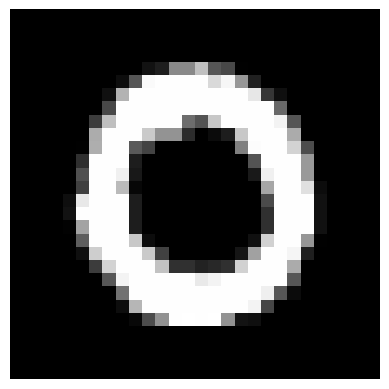

label: 0


In [62]:
#Visualize input data 

pixels = train_data.iloc[1,1:]
# Convert to NumPy array and reshape to 28x28
img = np.array(pixels).reshape((28, 28))

# Show the image
plt.imshow(img, cmap="gray")  # "gray" colormap makes it black & white
plt.axis("off")               # hide axes
plt.show()

print(f"label: {train_data.iloc[1,0]}")

## Preparing the data for training 

Before feeding the data into a neural network, we need to make sure it has the right format and scale. Each step below transforms the raw dataset into something the model can understand and learn from:  

<u> **x  input** </u>

1. We start by transforming the x input into a pandas dataframe, and converting all values to numeric. If anything cannot be converted, it’s replaced with 0. This guarantees the model won’t see unexpected values.
2. We normalize each pixel value into a range between 0 and 1. This is done because neural networks prefer small inputs. Scaling them to 0–1 avoids very large numbers inside the network (from multiplications and activations) which can slow learning.
3. The image data was stored as a 784 pixel flat row, we reshape it back into 28×28 images with 1 channel (grayscale). (the -1 at the beginning indicates we do this to all samples)

Our x input is finally ready to be fed into the neural network ! The dataframe contains 42'000 samples each of size 28 x 28 in grayscale. 

<u> **y input** </u>

1. For the y data we need to convert categorical variables into a binary format (0 and 1), to do so we use a method called **one hot encoding**. For each label a column is created. As we have 10 labels it will create an array of size 10 and then place a `1` in the position corresponding to the correct class while filling the other positions with `0`.
i.e : 

- **Label 0** → [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
- **Label 1** → [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
- **Label 2** → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  
- **Label 3** → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]  
- **Label 4** → [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  

etc...

This approach is important because the labels **have no inherent order**. If we simply left them as numbers, the model might mistakenly assume that `9` is “greater” or “closer” to `8` than to `0`. One-hot encoding eliminates this risk by treating each digit as an independent category, ensuring the model understands them as separate classes rather than ordered values.  


In [40]:
# Prepare the data for training

x = pd.DataFrame(x) # transform x into a pandas DataFrame
x = x.apply(pd.to_numeric, errors='coerce').fillna(0) # Convert to numeric values only 
x = x.values / 255.0    # Normalize pixel values to [0, 1]
x = x.reshape(-1, 28,28, 1) # Reshape to (num_samples, 28, 28, 1 = grayscale) 

print(f"Shape of x after preparation: {x.shape}")

# Convert labels to categorical 
y = to_categorical(y, num_classes=10)
print(f"Shape of y after one-hot encoding:{y.shape}")

Shape of x after preparation: (42000, 28, 28, 1)
Shape of y after one-hot encoding:(42000, 10)


In [ ]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(f"Shape of x_train: {x_train.shape}, y_train: {y_train.shape}")

Shape of x_train: (33600, 28, 28, 1), y_train: (33600, 10)


In [ ]:
#Import the model and build the neural network

model = Sequential([          # Model definition
    Input(shape=(28, 28, 1)), # Defining the input : each image is 28x28 pixels with 1 channel (grayscale)

    #-- First convolutional layer--
    Conv2D(32, 3, activation ='relu', padding='same'), 
    BatchNormalization(),
    MaxPooling2D(pool_size=2),

    #-- Second convolutional layer--
    Conv2D(64, 3, activation ='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),

    #-- Classifier --
    Flatten(),                # Flatten the 2D image to a 1D vector
    Dense(128, activation='relu'), # First Hidden layer with 128 neurons and ReLU activation
    Dense(64, activation='relu'),  # Second Hidden layer with 64 neurons and ReLU activation
    Dropout(0.3),
    Dense(10, activation='softmax')# Output layer with 10 neurons and softmax activation
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
# Adam to update weights + categorical_crossentropy to determine how close the predictions are to the true labels

# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

In [ ]:
history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_val, y_val), callbacks=[early_stop])

Epoch 1/20
525/525 [==============================] - 68s 125ms/step - loss: 0.2348 - accuracy: 0.9290 - val_loss: 0.0881 - val_accuracy: 0.9765
Epoch 2/20
525/525 [==============================] - 71s 135ms/step - loss: 0.0764 - accuracy: 0.9782 - val_loss: 0.0658 - val_accuracy: 0.9794
Epoch 3/20
525/525 [==============================] - 68s 130ms/step - loss: 0.0525 - accuracy: 0.9852 - val_loss: 0.0675 - val_accuracy: 0.9794
Epoch 4/20
525/525 [==============================] - 68s 130ms/step - loss: 0.0417 - accuracy: 0.9881 - val_loss: 0.0763 - val_accuracy: 0.9812
Epoch 5/20
525/525 [==============================] - 71s 135ms/step - loss: 0.0299 - accuracy: 0.9910 - val_loss: 0.0450 - val_accuracy: 0.9880
Epoch 6/20
525/525 [==============================] - 65s 123ms/step - loss: 0.0264 - accuracy: 0.9921 - val_loss: 0.0567 - val_accuracy: 0.9868
Epoch 7/20
525/525 [==============================] - 64s 122ms/step - loss: 0.0213 - accuracy: 0.9936 - val_loss: 0.0554 - val_ac

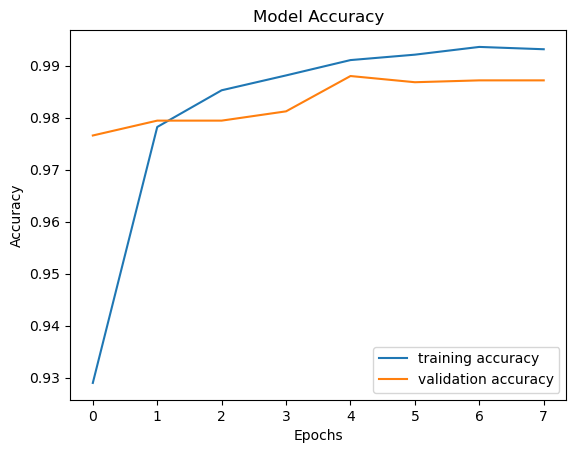

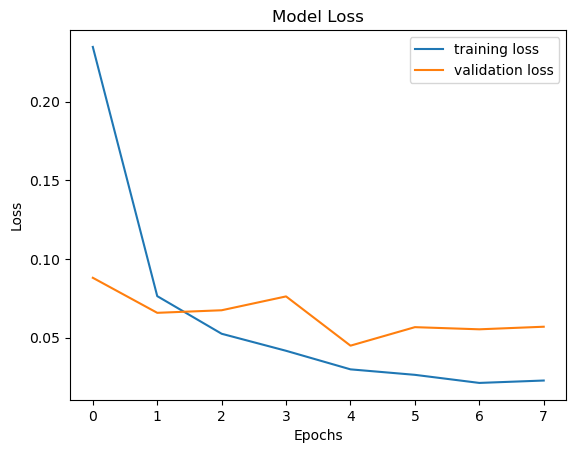

In [51]:
# Display training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Diplay training loss and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [52]:
model.save('trained_model.h5')  # Save the trained model

2025-08-23 15:02:52.096620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


175/175 [==============================] - 4s 19ms/step


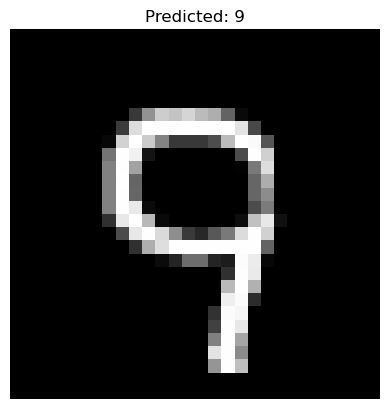

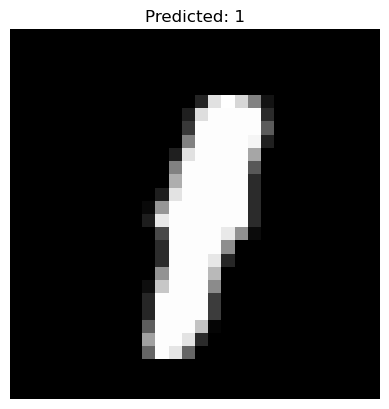

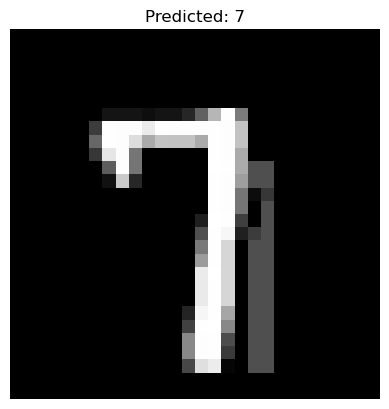

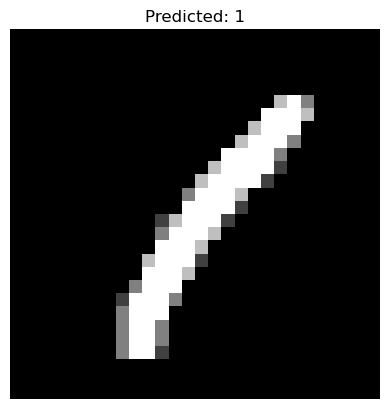

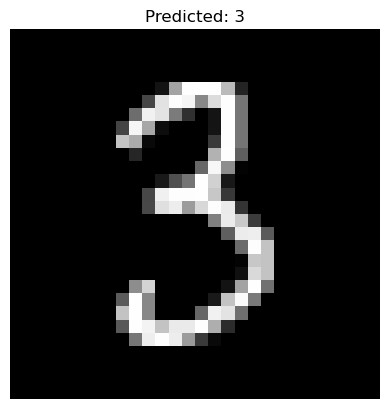

In [3]:
# Test predictions on test dataset 
model = load_model('trained_model.h5') 

test_data = pd.read_csv('data/test_data.csv')
X_test = test_data.values / 255.0
X_test = X_test.reshape(-1, 28, 28, 1)
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
for i in range(5):
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {predicted_labels[i]}")
    plt.axis('off')
    plt.show()

